In [8]:
%load_ext rpy2.ipython
%R library(dplyr); library(ggplot2)

//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


array(['ggplot2', 'dplyr', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], 
      dtype='|S9')

In [9]:
from __future__ import print_function
import glob
import pandas as pd
import os


recruits = glob.glob("../data/gt150/*_recruit_info.txt")

In [10]:
recruits

['../data/gt150/LVP-2_recruit_info.txt',
 '../data/gt150/LVP-4_recruit_info.txt',
 '../data/gt150/LVP-5_recruit_info.txt',
 '../data/gt150/LVP-8_recruit_info.txt']

In [11]:
for i, r in enumerate(recruits):
    din = pd.read_csv(r, sep="\t")
    din = din.rename(columns={"Unnamed: 0":"sag"})
#    din['STAT'] = din['stat']
    #din = din.set_index(din.stat)

    tin = din.transpose()
    tin.columns = tin.iloc[0]
    tin = tin.iloc[1:]
    tin['metagenome'] = os.path.basename(r).split("_")[0] 
    sags = list(tin.index)
    tin['SAG'] = sags
    if i == 0:
        newdf = pd.DataFrame()
    
    newdf = pd.concat([tin, newdf])

newdf = newdf.convert_objects(convert_numeric=True)
#newdf = pd.to_numeric(newdf, errors='ignore')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [12]:
%%R -i newdf
newdf %>% head %>% print
str(newdf)

  perfect_best_site unambiguous Percent_scaffolds_with_any_coverage
1                 0           7                              100.00
2                79         949                               55.84
3               558        1832                               77.66
4                37         169                               34.67
5               435        1009                               80.70
6               276         444                               26.34
  Percent_of_reference_bases_covered Average_coverage Reads_Used metagenome
1                               0.01             0.00   11004409      LVP-8
2                               2.31             0.13   11004409      LVP-8
3                               7.62             0.32   11004409      LVP-8
4                               1.01             0.04   11004409      LVP-8
5                               5.79             0.28   11004409      LVP-8
6                               0.86             0.03   11004409    

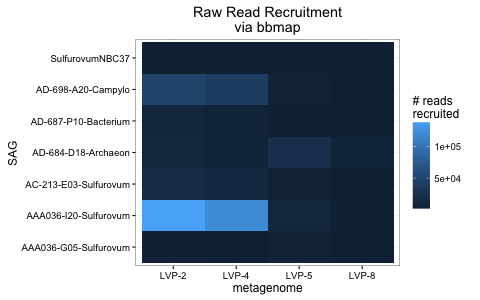

In [13]:
%%R -h 300
newdf %>% ggplot(aes(metagenome, SAG)) + geom_tile(aes(fill=as.numeric(as.character(unambiguous)))) + labs(fill="# reads\nrecruited", title="Raw Read Recruitment\nvia bbmap") + theme_bw()

### Now comparing bbmap output to blast results
* bbmapping done with only joined reads greater than 150bp

In [14]:
bbreads = pd.DataFrame(index = [u'SulfurovumNBC37', u'AAA036-G05-Sulfurovum', u'AAA036-I20-Sulfurovum',
       u'AC-213-E03-Sulfurovum', u'AD-698-A20-Campylo',
       u'AD-687-P10-Bacterium', u'AD-684-D18-Archaeon', u'total_reads'])

for r in recruits:
    df = pd.read_csv(r, sep="\t")
    df = df.set_index(df.columns[0])
    total_reads = df.loc['Reads_Used'].mean()
    df['total_reads'] = total_reads
    unam = pd.DataFrame(pd.Series(df.loc['unambiguous'], name = os.path.basename(r).split("_")[0]))
    bbreads = pd.merge(unam, bbreads, how='outer', left_index=True, right_index=True)
bbreads

blastdf = pd.read_csv("../data/blast_hits_95pct_150len.txt", sep="\t", header = None)
blastdf.columns = ['pair', 'metagenome', 'sag', 'reads']

sag_list = [u'SulfurovumNBC37', u'AAA036-G05-Sulfurovum', u'AAA036-I20-Sulfurovum',
       u'AC-213-E03-Sulfurovum', u'AD-698-A20-Campylo',
       u'AD-687-P10-Bacterium', u'AD-684-D18-Archaeon']

blast_comp = blastdf.loc[blastdf['sag'].isin(sag_list)].pivot(index='sag', columns='metagenome', values='reads')

bbreads.columns = [i.replace("-","")+"_bbmap" for i in list(bbreads.columns)]
#bbreads['method'] = 'bbmap'

together = pd.merge(bbreads, blast_comp, left_index=True, right_index=True)

together.reindex_axis(sorted(together.columns), axis=1)

,LVP2,LVP2_bbmap,LVP4,LVP4_bbmap,LVP5,LVP5_bbmap,LVP8,LVP8_bbmap
AAA036-G05-Sulfurovum,1919,1481,1074,903,3428,2770,1208,949
AAA036-I20-Sulfurovum,112703,138312,97225,119010,7732,9718,1405,1832
AC-213-E03-Sulfurovum,11701,18363,9192,14062,1423,2323,108,169
AD-684-D18-Archaeon,7984,9251,4609,5310,19195,22946,3388,4295
AD-687-P10-Bacterium,5533,8642,3416,5201,772,1191,271,444
AD-698-A20-Campylo,34746,48295,29450,40036,2451,3430,695,1009
SulfurovumNBC37,406,249,324,111,77,10,43,7


### Heatmap of the two different recruitment methods side by side

In [15]:
newdf = newdf.rename(columns={'SAG':'sag', 'unambiguous':'reads'})

In [16]:
blast_long = blastdf.loc[blastdf['sag'].isin(sag_list)]
a = blast_long[['sag','metagenome','reads']]
a['method'] = 'blast'

In [17]:
newdf['metagenome'] = [i.replace("-","") for i in newdf['metagenome']]

In [18]:
b = newdf[['sag', 'metagenome', 'reads']]
b['method'] = 'bbmap'

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [19]:
forr = pd.concat([b,a])

In [20]:
forr['mg_method'] = forr['metagenome']+"_"+forr['method']

'data.frame':	56 obs. of  5 variables:
 $ sag       : Factor w/ 7 levels "AAA036-G05-Sulfurovum",..: 7 1 2 3 6 5 4 7 1 2 ...
 $ metagenome: Factor w/ 4 levels "LVP2","LVP4",..: 4 4 4 4 4 4 4 3 3 3 ...
 $ reads     : num  7 949 1832 169 1009 ...
 $ method    : Factor w/ 2 levels "bbmap","blast": 1 1 1 1 1 1 1 1 1 1 ...
 $ mg_method : Factor w/ 8 levels "LVP2_bbmap","LVP2_blast",..: 7 7 7 7 7 7 7 5 5 5 ...
NULL


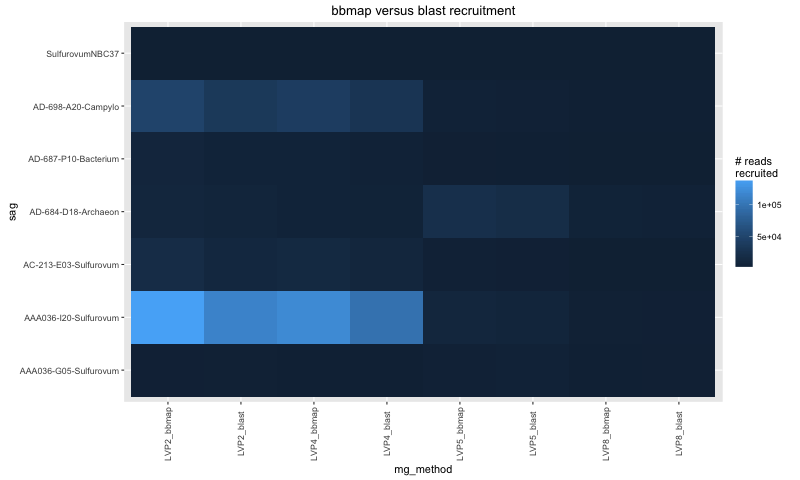

In [21]:
%%R -i forr -w 800
str(forr) %>% print
sorted = forr[order(as.character(forr$mg_method)),]
ggplot(sorted, aes(mg_method, sag)) + geom_tile(aes(fill=as.numeric(as.character(reads)))) -> p1
p1 <- p1 + theme(axis.text.x  = element_text(angle=90, vjust=0.5)) + labs(fill="# reads\nrecruited", title = "bbmap versus blast recruitment")

plot(p1)


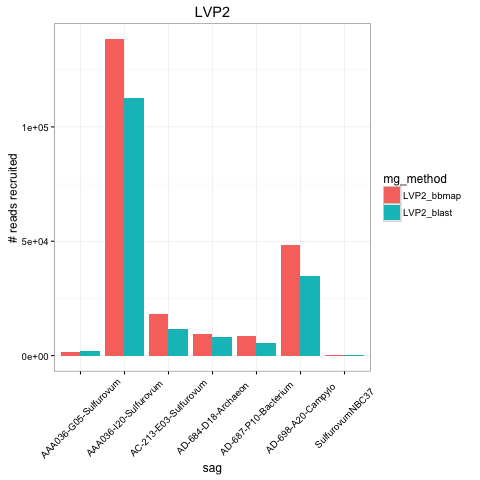

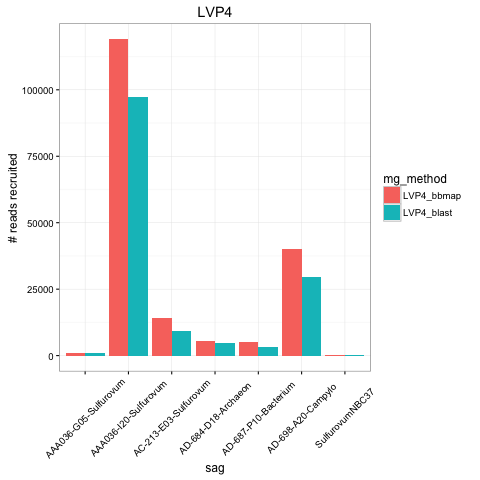

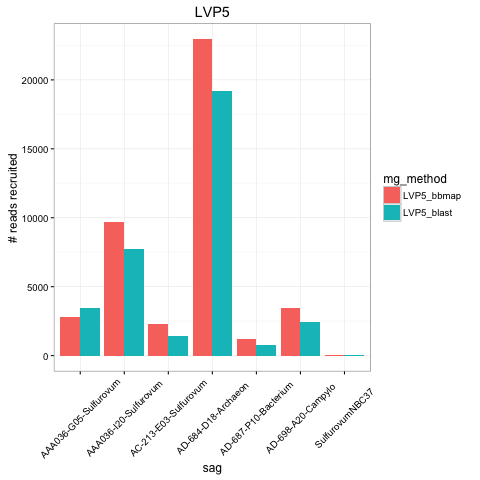

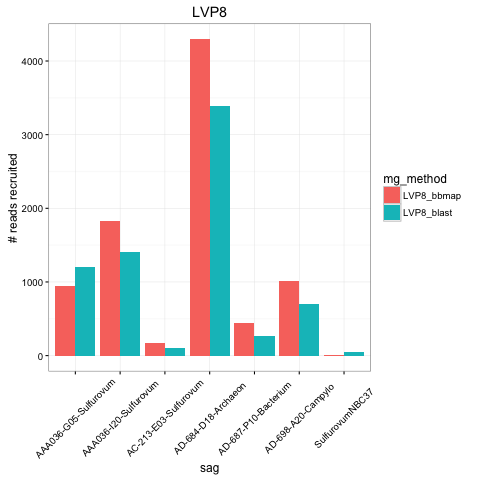

In [22]:
%%R
for (m in unique(sorted$metagenome)){
    sorted %>% filter(metagenome == m) -> to_use
    to_use %>% ggplot(aes(mg_method, sag)) + geom_tile(aes(fill=as.numeric(as.character(reads)))) -> p1
    p1 <- p1 + theme(axis.text.x  = element_text(angle=90, vjust=0.5)) + labs(fill="# reads\nrecruited", title = m)

    #plot(p1)
    
    to_use %>% ggplot(aes(sag, reads)) + geom_bar(stat="identity", aes(fill=mg_method), position="dodge") -> p2
    p2 <- p2 +theme_bw() + theme(axis.text.x  = element_text(angle=45, vjust=0.5)) + labs(y="# reads recruited", title=m)
    plot(p2)
    }